In [1]:
import numpy as np
import os
import time
import pydicom
import matplotlib.pyplot as plt
import nibabel as nib

(320, 320, 179)


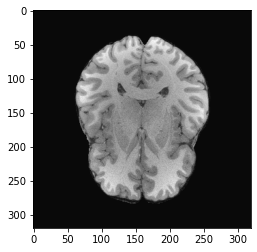

In [120]:
## baseline SR
root = '/mnt/beta/djboonstoppel/Code'
folder = 'baseline'
source = 'hcp'
no = 120111
fname = str(no)+'_3T_T1w_MPR1_img_SR'
nr_hcp = 30
nr_sim = 0
path = os.path.join(root,
                    'output',
                    folder,
                    source,
                    'hcp{:02d}_sim{:02d}'.format(nr_hcp, nr_sim),
                    'SR',
                    fname+'_hcp{:02d}_sim{:02d}.nii.gz'.format(nr_hcp, nr_sim)).replace("\\","/")
nifty = nib.load(path)
array = nifty.get_fdata()
print(array.shape)
array = np.rot90(array, axes = (1,0))
plt.imshow(array[:,:,100], cmap='gray')

In [121]:
def write2dicom(template_path, output_path, data, patient_id, exp_name, window_width = 3500, window_center = 1750):
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")
    lz = data.shape[2]
    znum = 0
    for root, dirs, files in os.walk(template_path):
        files.sort()
        for name in files:
            if znum > (lz - 1):
                break
            image_name = os.path.join(root,name)
            image = pydicom.dcmread(image_name)
            image.WindowWidth = window_width
            image.WindowCenter = window_center
            SeriesInstanceUID = "%s" %image.SeriesInstanceUID
            SOPInstanceUID = "%s" %image.SOPInstanceUID
            UIDstart = SeriesInstanceUID[:29]
            SOPstart = SOPInstanceUID[:29]
            SeriesInstanceUID = UIDstart+modification_date+modification_time
            SOPInstanceUI = SOPstart+modification_date+modification_time + str(znum)
            image.SeriesInstanceUID = SeriesInstanceUID
            image.SOPInstanceUID = SOPInstanceUI
            image.PatientID = str(patient_id)
            image.StudyID = exp_name
            image.PatientPosition = 'HFS'
            image.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
            tempimage = (data[:,:,znum]).astype(np.uint16)
            image.PixelData = tempimage.tobytes()
            outname = 'IMG{:04d}.dcm'.format(znum+1)
            os.makedirs(output_path, exist_ok=True)
            outfile = os.path.join(output_path,'%s' %outname)
            pydicom.write_file(outfile, image)
            znum += 1

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.35966058521016292344636266734490351
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.1.2'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'MPR']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.20221012171023178
(0008, 

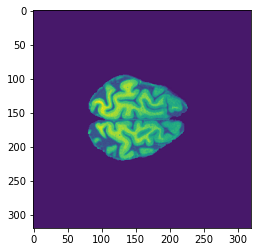

In [111]:
template_path = 'data/brain_real_t1w_mri/HCP/dicom_template_hr'
output_path = 'data/brain_real_t1w_mri/HCP/dicom_test'
data = array
exp_name = 'hcp30_sim0'
patient_id = no

write2dicom(template_path, output_path, data, patient_id, exp_name)

In [122]:
def nifti2dicom_debug(dcm_template_path, dcm_output_path, nifti_input_path, patient_id, exp_name, window_width = 3500, window_center = 1750):
    nifti = nib.load(nifti_input_path)
    data = np.rot90(nifti.get_fdata(), axes = (1,0))
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    lz = data.shape[2]
    znum = 0
    for root, dirs, files in os.walk(dcm_template_path):
        files.sort()
        for name in files:
            if znum > (lz - 1):
                break
            image_name = os.path.join(root,name)
            image = pydicom.dcmread(image_name)
            image.WindowWidth = window_width
            image.WindowCenter = window_center
            SeriesInstanceUID = "%s" %image.SeriesInstanceUID
            SOPInstanceUID = "%s" %image.SOPInstanceUID
            UIDstart = SeriesInstanceUID[:29]
            SOPstart = SOPInstanceUID[:29]
            SeriesInstanceUID = UIDstart+modification_date+modification_time
            SOPInstanceUI = SOPstart+modification_date+modification_time + str(znum)
            image.SeriesInstanceUID = SeriesInstanceUID
            image.SOPInstanceUID = SOPInstanceUI
            image.PatientID = str(patient_id)
            image.StudyID = exp_name

            tempimage = (data[:,:,znum]).astype(np.uint16)
            image.PixelData = tempimage.tobytes()
            outname = 'IMG{:04d}.dcm'.format(znum+1)
            os.makedirs(dcm_output_path, exist_ok=True)
            outfile = os.path.join(dcm_output_path,'%s' %outname)
            pydicom.write_file(outfile, image)
            znum += 1

In [81]:
dcm_template_path = 'data/brain_real_t1w_mri/HCP/dicom_template_hr'
dcm_output_path = 'data/brain_real_t1w_mri/HCP/dicom_test'

root = '/mnt/beta/djboonstoppel/Code'
folder = 'baseline'
source = 'hcp'
no = 120111
nr_hcp = 30
nr_sim = 0
path = os.path.join(root, 'output', folder, source,
                    'hcp{:02d}_sim{:02d}'.format(nr_hcp, nr_sim), 'SR',
                    str(no)+'_3T_T1w_MPR1_img_SR_hcp{:02d}_sim{:02d}.nii.gz'.format(nr_hcp, nr_sim)).replace("\\","/")
nifti2dicom_debug(dcm_template_path, dcm_output_path, path, no, exp_name)

/mnt/beta/djboonstoppel/Code/output/baseline/hcp/hcp30_sim00/SR/120111_3T_T1w_MPR1_img_SR_hcp30_sim00.
/mnt/beta/djboonstoppel/Code/output/baseline/hcp/hcp30_sim00/SR/dicom


In [13]:
def nifti2dicom(nifti_input_path,
                  source,
                  patient_id,
                  exp_name,
                  resolution = 'hr',
                  window_width = None,
                  window_center = None,
                  root = '/mnt/beta/djboonstoppel/Code'):
    if source == 'sim':
        if window_width is None and window_center is None:
            window_width = 4000
            window_center = 2000
        dcm_template_path = root + '/data/brain_simulated_t1w_mri/1mm_07mm/dicom_template_' + resolution
    elif source == 'MRBrainS18':
        if window_width is None and window_center is None:
            window_width = 1400
            window_center = 700
        dcm_template_path = root + '/data/brain_real_t1w_mri/MRBrainS18/dicom_template_' + resolution
    elif source == 'oasis':
        if window_width is None and window_center is None:
            window_width = 1600
            window_center = 800
        dcm_template_path = root + '/data/brain_real_t1w_mri/OASIS/dicom_template_' + resolution
    elif source == 'hcp':
        if window_width is None and window_center is None:
            window_width = 3500
            window_center = 1750
        dcm_template_path = root + '/data/brain_real_t1w_mri/HCP/dicom_template_' + resolution
    else:
        raise ValueError("Dataset '{}' not implemented".format(source))

    dcm_output_path = nifti_input_path[:-7]
    nifti = nib.load(nifti_input_path)
    data = np.rot90(nifti.get_fdata(), axes = (1,0))

    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    lz = data.shape[2]
    znum = 0
    for root, dirs, files in os.walk(dcm_template_path):
        files.sort()
        for name in files:
            if znum > (lz - 1):
                break
            image_name = os.path.join(root,name)
            try:
                image = pydicom.dcmread(image_name)

                image.WindowWidth = window_width
                image.WindowCenter = window_center
                SeriesInstanceUID = "%s" %image.SeriesInstanceUID
                SOPInstanceUID = "%s" %image.SOPInstanceUID
                UIDstart = SeriesInstanceUID[:29]
                SOPstart = SOPInstanceUID[:29]
                SeriesInstanceUID = UIDstart+modification_date+modification_time
                SOPInstanceUI = SOPstart+modification_date+modification_time + str(znum)
                image.SeriesInstanceUID = SeriesInstanceUID
                image.SOPInstanceUID = SOPInstanceUI
                image.PatientID = str(patient_id)
                image.StudyID = exp_name

                tempimage = (data[:,:,znum]).astype(np.uint16)
                image.PixelData = tempimage.tobytes()
                outname = 'IMG{:04d}.dcm'.format(znum+1)
                os.makedirs(dcm_output_path, exist_ok=True)
                outfile = os.path.join(dcm_output_path,'%s' %outname)
                pydicom.write_file(outfile, image)
                znum += 1
            except:
                print("Ignoring: %s" % image_name)
    print("Finished")

In [85]:
root = '/mnt/beta/djboonstoppel/Code'
folder = 'baseline'
source = 'hcp'
no = 120111
nr_hcp = 0
nr_sim = 50
exp_name = 'hcp{:02d}_sim{:02d}'.format(nr_hcp, nr_sim)
path = os.path.join(root, 'output', folder, source,
                    exp_name, 'SR',
                    str(no)+'_3T_T1w_MPR1_img_SR_'+exp_name+'.nii.gz')

nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=exp_name)

In [4]:
root = '/mnt/beta/djboonstoppel/Code'
folder = 'sweep-archs'
source = 'hcp'
# no = 101006 #sim
no = 120111 #hcp
# alpha_pixel = 1
# alpha_edge = 1
# alpha_perceptual = 1
# alpha_adversarial = 0.1
# exp_name = 'pixel{}_edge{}_vgg{}_gan{}'.format(alpha_pixel,
#                                                alpha_edge,
#                                                alpha_perceptual,
#                                                alpha_adversarial).replace('.', '')
# gan_mode = 'wgan'
# ragan = 'True'
# exp_name = 'mode={}_ragan={}'.format(gan_mode, ragan)

generator='ESRGAN3'
exp_name = 'generator={}'.format(generator)

path = os.path.join(root, 'output', folder, source,
                    exp_name, 'SR',
                    str(no)+'_3T_T1w_MPR1_img_SR_'+exp_name+'.nii')
                   # '08-Apr-2022_Ernst_labels_{:06d}_3T_T1w_MPR1_img_act_1_contrast_1_SR_'.format(no)+exp_name+'.nii')
nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=exp_name)

Finished


In [6]:
root = '/mnt/beta/djboonstoppel/Code'
source = 'hcp'
no = 120111
resolution = 'LR'
path = os.path.join(root, 'data/brain_real_t1w_mri/', source.upper(), resolution,
                    str(no)+'_3T_T1w_MPR1_img.nii.gz')
nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=resolution,
              resolution=resolution.lower())

Finished


In [11]:
root = '/mnt/beta/djboonstoppel/Code'
source = 'sim'
no = 101006
resolution = 'LR'
path = os.path.join(root, 'data/brain_simulated_t1w_mri/1mm_07mm', resolution+'_img',
                    "08-Apr-2022_Ernst_labels_{:06d}_3T_T1w_MPR1_img_act_1_contrast_1_Res_1_1_1_img.nii.gz".format(no))
nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=resolution,
              resolution=resolution.lower())

Finished


In [24]:
root = '/mnt/beta/djboonstoppel/Code'
source = 'MRBrainS18'
no = 1
resolution = 'LR'
path = os.path.join(root, 'data/brain_real_t1w_mri/', source, 'GT',
                    'p{:01d}_reg_T1.nii.gz'.format(no))
nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=resolution,
              resolution=resolution.lower())

Finished


In [12]:
root = '/mnt/beta/djboonstoppel/Code'
source = 'oasis'
no = 1
resolution = 'LR'
path = os.path.join(root, 'data/brain_real_t1w_mri/', source.upper(), resolution,
                    "OAS1_{:04d}_MR1_mpr_n4_anon_111_t88_masked_gfc.nii.gz".format(no))
nifti2dicom(nifti_input_path=path,
              source=source,
              patient_id=no,
              exp_name=resolution,
              resolution=resolution.lower())

/mnt/beta/djboonstoppel/Code/data/brain_real_t1w_mri/OASIS/LR/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc
Finished


In [19]:
root = '/mnt/beta/djboonstoppel/Code'
folder = 'sweep-archs'
source = 'MRBrainS18'
no = 1
generator='ESRGAN'
exp_name = 'generator={}'.format(generator)

path = os.path.join(root, 'output', folder, 'mrbrains', exp_name, 'SR',
                    'p{:01d}_reg_T1_SR_'.format(no)+exp_name+'.nii')
nifti2dicom(nifti_input_path=path,
            source=source,
            patient_id=no,
            exp_name=exp_name,
            resolution='lr')

Finished


In [23]:
root = '/mnt/beta/djboonstoppel/Code'
folder = 'sweep-archs'
source = 'oasis'
no = 1
generator='ESRGAN'
exp_name = 'generator={}'.format(generator)

path = os.path.join(root, 'output', folder, source, exp_name, 'SR',
                    'OAS1_{:04d}_MR1_mpr_n4_anon_111_t88_masked_gfc_SR_'.format(no)+exp_name+'.nii')
nifti2dicom(nifti_input_path=path,
            source=source,
            patient_id=no,
            exp_name=exp_name,
            resolution='lr')

Finished
